=== Compact Summary of Class-Imbalance Experiments ===
                                          name  train_acc  val_acc  test_acc  \
0    LogReg: baseline (no class_weight, t=0.5)      0.976    0.980     0.985   
1      LogReg: class_weight='balanced' (t=0.5)      0.945    0.950     0.960   
2  LogReg: balanced + tuned threshold (t=0.88)      0.978    0.985     0.980   
3        RandomForest: class_weight='balanced'      1.000    0.975     0.980   

   train_precision  train_recall  train_f1  val_precision  val_recall  val_f1  \
0            0.898         0.862     0.880          0.884       0.927   0.905   
1            0.657         0.967     0.783          0.684       0.951   0.796   
2            0.936         0.837     0.884          0.927       0.927   0.927   
3            1.000         1.000     1.000          0.897       0.854   0.875   

   test_precision  test_recall  test_f1  roc_auc  pr_auc  generalisation_gap  \
0           0.973        0.878    0.923    0.996   0.974  

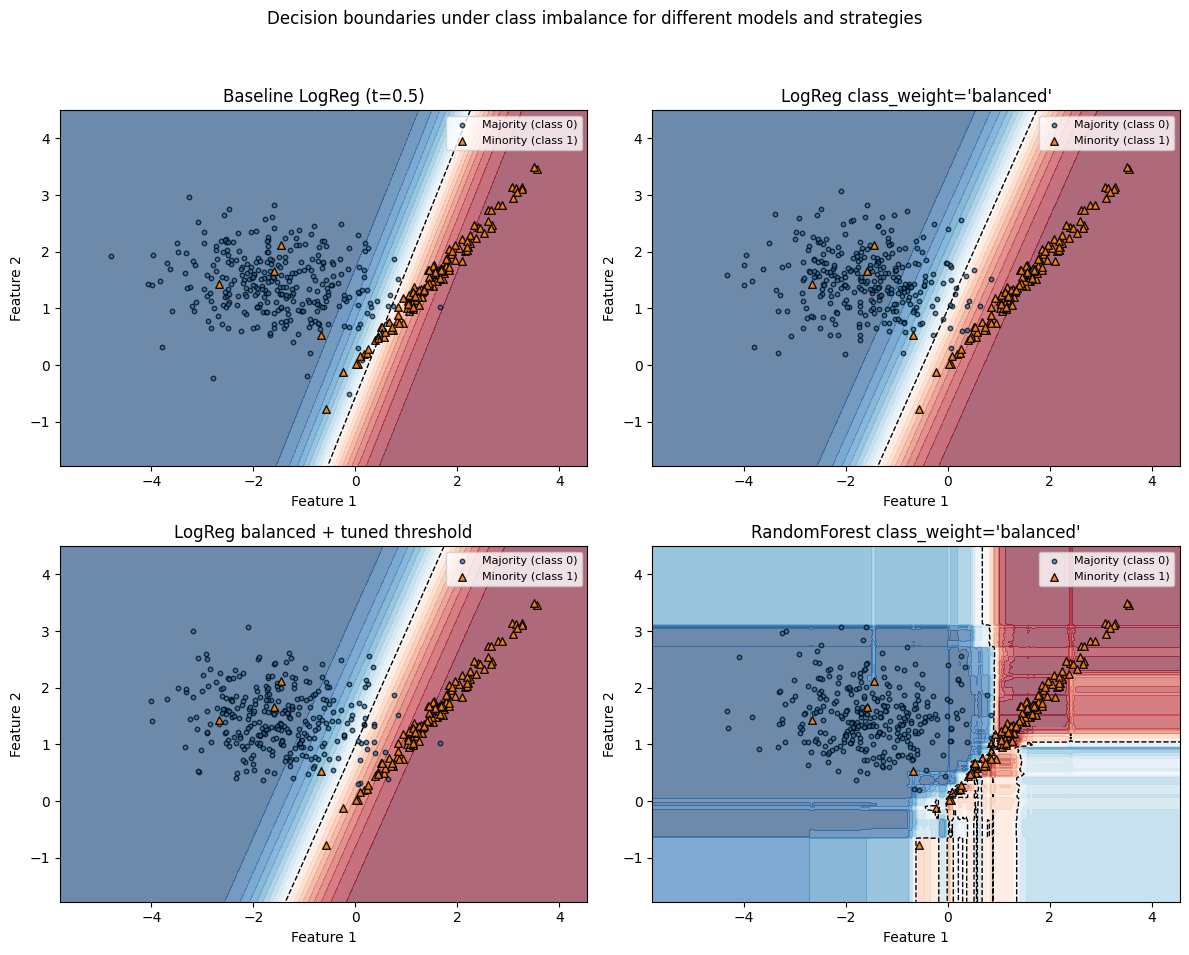

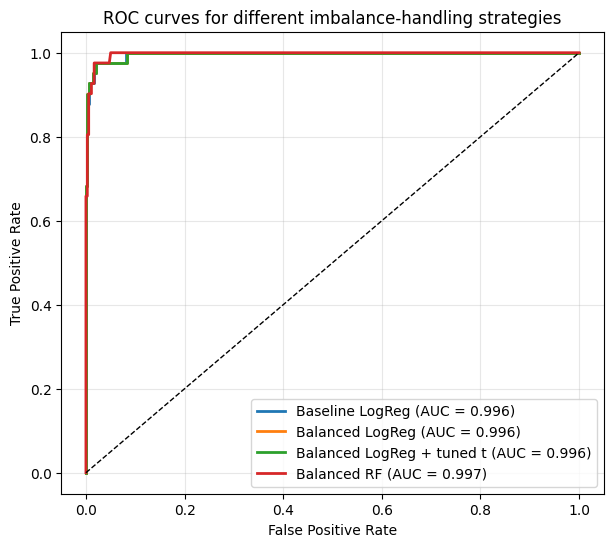

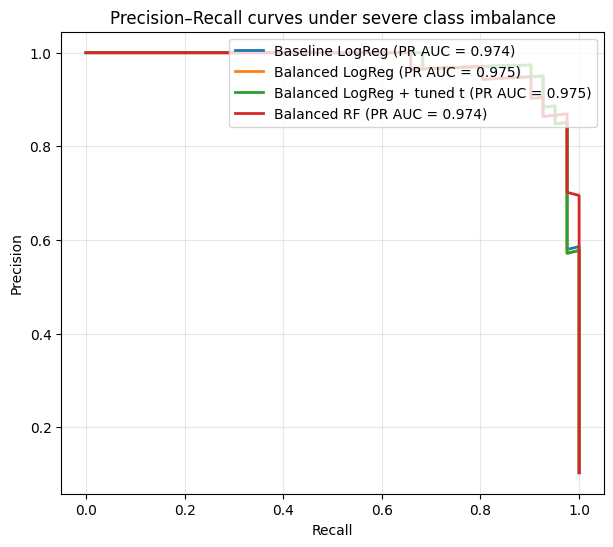

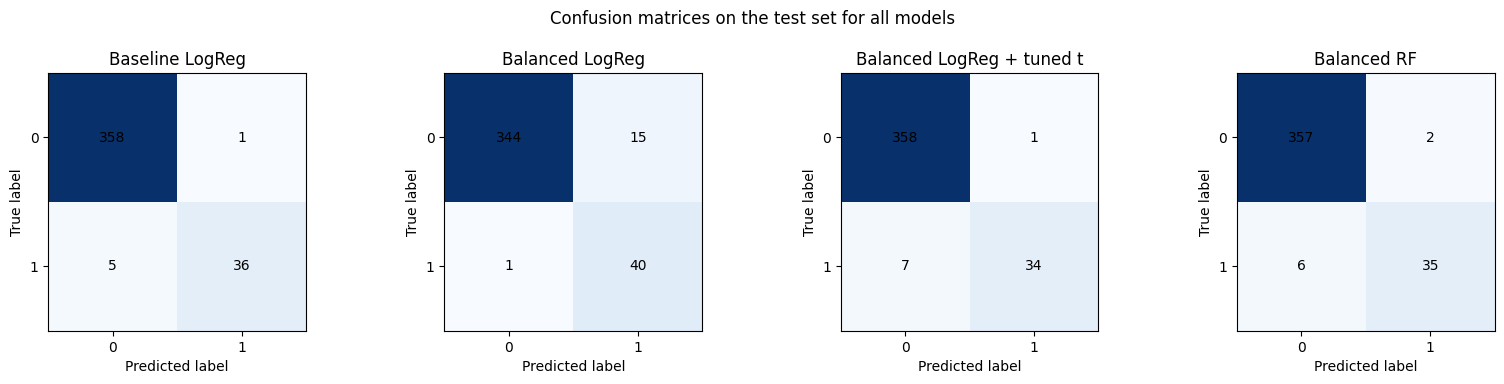

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    precision_recall_curve,
    auc,
    confusion_matrix,
)

# -----------------------------
# 1. Data generation (imbalanced binary classification)
# -----------------------------
RANDOM_STATE = 42

X, y = make_classification(
    n_samples=2000,
    n_features=2,           # 2D so we can visualise decision boundaries
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_clusters_per_class=1,
    weights=[0.9, 0.1],     # strong class imbalance
    flip_y=0.01,
    class_sep=1.5,
    random_state=RANDOM_STATE,
)

# Train / validation / test split (60 / 20 / 20), stratified
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=RANDOM_STATE
)  # 0.25 * 0.8 = 0.2

# Standardise features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 2. Helper functions
# -----------------------------
def evaluate_model(name, model, X_tr, y_tr, X_va, y_va, X_te, y_te, threshold=0.5):
    """Train model, then evaluate on train/val/test using given threshold."""
    model.fit(X_tr, y_tr)

    # Probabilities (needed for thresholding and curves)
    if hasattr(model, "predict_proba"):
        p_tr = model.predict_proba(X_tr)[:, 1]
        p_va = model.predict_proba(X_va)[:, 1]
        p_te = model.predict_proba(X_te)[:, 1]
    else:
        # Fallback to decision function if no predict_proba
        def sigmoid(z):
            return 1.0 / (1.0 + np.exp(-z))
        p_tr = sigmoid(model.decision_function(X_tr))
        p_va = sigmoid(model.decision_function(X_va))
        p_te = sigmoid(model.decision_function(X_te))

    # Hard labels via threshold
    y_tr_hat = (p_tr >= threshold).astype(int)
    y_va_hat = (p_va >= threshold).astype(int)
    y_te_hat = (p_te >= threshold).astype(int)

    metrics = {
        "name": name,
        "train_acc": accuracy_score(y_tr, y_tr_hat),
        "val_acc": accuracy_score(y_va, y_va_hat),
        "test_acc": accuracy_score(y_te, y_te_hat),
        "train_precision": precision_score(y_tr, y_tr_hat, zero_division=0),
        "train_recall": recall_score(y_tr, y_tr_hat, zero_division=0),
        "train_f1": f1_score(y_tr, y_tr_hat, zero_division=0),
        "val_precision": precision_score(y_va, y_va_hat, zero_division=0),
        "val_recall": recall_score(y_va, y_va_hat, zero_division=0),
        "val_f1": f1_score(y_va, y_va_hat, zero_division=0),
        "test_precision": precision_score(y_te, y_te_hat, zero_division=0),
        "test_recall": recall_score(y_te, y_te_hat, zero_division=0),
        "test_f1": f1_score(y_te, y_te_hat, zero_division=0),
        "generalisation_gap": accuracy_score(y_tr, y_tr_hat) - accuracy_score(y_te, y_te_hat),
        "threshold": threshold,
    }

    # ROC and PR curves on test
    fpr, tpr, _ = roc_curve(y_te, p_te)
    prec, rec, _ = precision_recall_curve(y_te, p_te)
    metrics["roc_auc"] = auc(fpr, tpr)
    metrics["pr_auc"] = auc(rec, prec)  # note order rec,prec

    aux = {
        "p_te": p_te,
        "y_te_hat": y_te_hat,
        "fpr": fpr,
        "tpr": tpr,
        "prec": prec,
        "rec": rec,
        "confusion": confusion_matrix(y_te, y_te_hat),
        "model": model,
    }
    return metrics, aux

def find_best_threshold(prob_val, y_val, metric="f1"):
    """Grid-search a threshold on validation probabilities."""
    thresholds = np.linspace(0.1, 0.9, 81)
    best_t = 0.5
    best_score = -np.inf
    for t in thresholds:
        y_hat = (prob_val >= t).astype(int)
        if metric == "f1":
            score = f1_score(y_val, y_hat, zero_division=0)
        else:
            raise ValueError("Unsupported metric")
        if score > best_score:
            best_score = score
            best_t = t
    return best_t, best_score

# -----------------------------
# 3. Define and evaluate models
# -----------------------------
results = []
aux_info = {}

# 3.1 Baseline logistic regression (no class weighting, threshold 0.5)
log_reg_base = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000,
    random_state=RANDOM_STATE,
)
m_base, aux_base = evaluate_model(
    "LogReg: baseline (no class_weight, t=0.5)",
    log_reg_base,
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    threshold=0.5,
)
results.append(m_base)
aux_info["Baseline LogReg"] = aux_base

# 3.2 Logistic regression with class_weight="balanced", threshold 0.5
log_reg_bal = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
)
m_bal, aux_bal = evaluate_model(
    "LogReg: class_weight='balanced' (t=0.5)",
    log_reg_bal,
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    threshold=0.5,
)
results.append(m_bal)
aux_info["Balanced LogReg"] = aux_bal

# 3.3 Logistic regression with class_weight='balanced' + tuned threshold
log_reg_bal_tuned = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
)
log_reg_bal_tuned.fit(X_train_scaled, y_train)
p_val_bal = log_reg_bal_tuned.predict_proba(X_val_scaled)[:, 1]
best_t, best_f1 = find_best_threshold(p_val_bal, y_val, metric="f1")

m_bal_tuned, aux_bal_tuned = evaluate_model(
    f"LogReg: balanced + tuned threshold (t={best_t:.2f})",
    log_reg_bal_tuned,
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    threshold=best_t,
)
results.append(m_bal_tuned)
aux_info["Balanced LogReg + tuned t"] = aux_bal_tuned

# 3.4 Random Forest with class_weight='balanced'
rf_bal = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=RANDOM_STATE,
)
m_rf, aux_rf = evaluate_model(
    "RandomForest: class_weight='balanced'",
    rf_bal,
    X_train_scaled, y_train,   # scaling not strictly needed for RF
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    threshold=0.5,
)
results.append(m_rf)
aux_info["Balanced RF"] = aux_rf

# -----------------------------
# 4. Summary table
# -----------------------------
df_results = pd.DataFrame(results)
metrics_cols = [
    "name",
    "train_acc", "val_acc", "test_acc",
    "train_precision", "train_recall", "train_f1",
    "val_precision", "val_recall", "val_f1",
    "test_precision", "test_recall", "test_f1",
    "roc_auc", "pr_auc",
    "generalisation_gap", "threshold",
]
df_results = df_results[metrics_cols]

print("=== Compact Summary of Class-Imbalance Experiments ===")
with pd.option_context("display.max_columns", None):
    print(df_results.round(3))

# -----------------------------
# 5. Visualisations
# -----------------------------
def plot_decision_boundary(ax, model, X, y, scaler, title):
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = scaler.transform(grid)

    if hasattr(model, "predict_proba"):
        Z = model.predict_proba(grid_scaled)[:, 1]
    else:
        Z = model.decision_function(grid_scaled)
        Z = 1.0 / (1.0 + np.exp(-Z))
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, levels=20, alpha=0.6, cmap="RdBu_r")
    ax.contour(xx, yy, Z, levels=[0.5], colors="k", linestyles="--", linewidths=1)

    # Downsample majority class for visibility
    mask_minority = y == 1
    mask_majority = y == 0
    idx_maj = np.where(mask_majority)[0]
    if len(idx_maj) > 300:
        idx_maj = np.random.choice(idx_maj, size=300, replace=False)
    idx_min = np.where(mask_minority)[0]
    X_plot = np.vstack([X[idx_maj], X[idx_min]])
    y_plot = np.hstack([y[idx_maj], y[idx_min]])

    ax.scatter(
        X_plot[y_plot == 0, 0],
        X_plot[y_plot == 0, 1],
        s=10,
        edgecolor="k",
        alpha=0.7,
        label="Majority (class 0)",
    )
    ax.scatter(
        X_plot[y_plot == 1, 0],
        X_plot[y_plot == 1, 1],
        s=30,
        marker="^",
        edgecolor="k",
        alpha=0.9,
        label="Minority (class 1)",
    )

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize=8)

# 5.1 Decision boundaries
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
ax_list = axes.ravel()

plot_decision_boundary(ax_list[0], aux_info["Baseline LogReg"]["model"], X_train, y_train, scaler, "Baseline LogReg (t=0.5)")
plot_decision_boundary(ax_list[1], aux_info["Balanced LogReg"]["model"], X_train, y_train, scaler, "LogReg class_weight='balanced'")
plot_decision_boundary(ax_list[2], aux_info["Balanced LogReg + tuned t"]["model"], X_train, y_train, scaler, "LogReg balanced + tuned threshold")
plot_decision_boundary(ax_list[3], aux_info["Balanced RF"]["model"], X_train, y_train, scaler, "RandomForest class_weight='balanced'")

fig.suptitle("Decision boundaries under class imbalance for different models and strategies", fontsize=12)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# 5.2 ROC curves on test set
plt.figure(figsize=(7, 6))
for (label, aux), color in zip(aux_info.items(), ["C0", "C1", "C2", "C3"]):
    fpr = aux["fpr"]
    tpr = aux["tpr"]
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_val:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for different imbalance-handling strategies")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# 5.3 Precision–Recall curves on test set
plt.figure(figsize=(7, 6))
for (label, aux), color in zip(aux_info.items(), ["C0", "C1", "C2", "C3"]):
    prec = aux["prec"]
    rec = aux["rec"]
    pr_auc_val = auc(rec, prec)
    plt.plot(rec, prec, label=f"{label} (PR AUC = {pr_auc_val:.3f})", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves under severe class imbalance")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)

# 5.4 Confusion matrices on test set
from matplotlib.colors import Normalize

def plot_confusion(ax, cm, title):
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues",
                   norm=Normalize(vmin=0, vmax=cm.max()))
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
titles = list(aux_info.keys())
for ax, (key, aux), title in zip(axes, aux_info.items(), titles):
    cm = aux["confusion"]
    plot_confusion(ax, cm, title)

fig.suptitle("Confusion matrices on the test set for all models", fontsize=12)
fig.tight_layout(rect=[0, 0.08, 1, 0.95])

plt.show()
